In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression



# Import Data

In [7]:
df = pd.read_excel('premiums_rest.xlsx', index_col=0)
df.head()


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
5,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [8]:
df.shape

(29904, 13)

In [9]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29904 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    29904 non-null  int64 
 1   gender                 29904 non-null  object
 2   region                 29904 non-null  object
 3   marital_status         29904 non-null  object
 4   number_of_dependants   29904 non-null  int64 
 5   bmi_category           29904 non-null  object
 6   smoking_status         29895 non-null  object
 7   employment_status      29903 non-null  object
 8   income_level           29895 non-null  object
 9   income_lakhs           29904 non-null  int64 
 10  medical_history        29904 non-null  object
 11  insurance_plan         29904 non-null  object
 12  annual_premium_amount  29904 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 3.2+ MB


# Handle Na & duplicate values

In [11]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [12]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [13]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [14]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.379910,23.364184,20892.303821
std,13.412657,1.431201,24.740339,6936.813440
min,26.000000,-3.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


In [15]:
df[df.number_of_dependants<0].shape

(50, 13)

In [16]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-1, -3])

In [17]:
df.number_of_dependants = abs(df.number_of_dependants)

Finding Outliers 

In [18]:
numeric_col = df.select_dtypes(['float64', 'int64']).columns
numeric_col

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

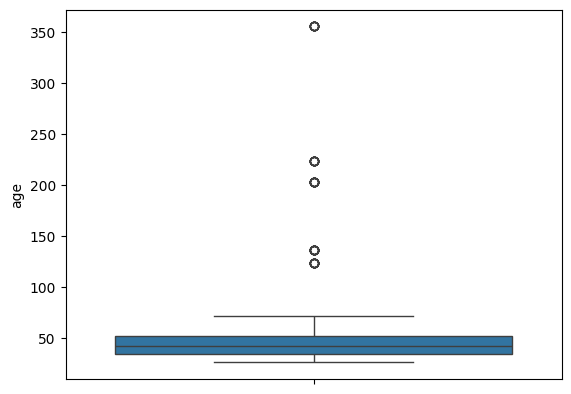

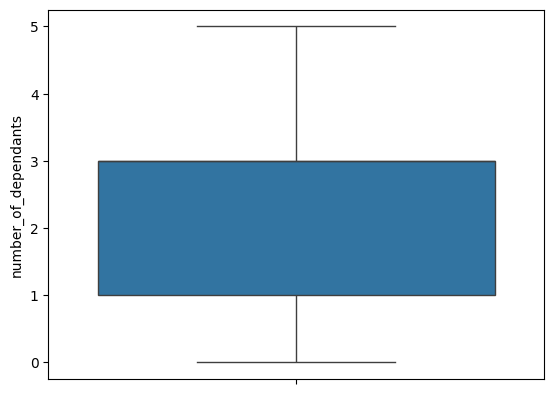

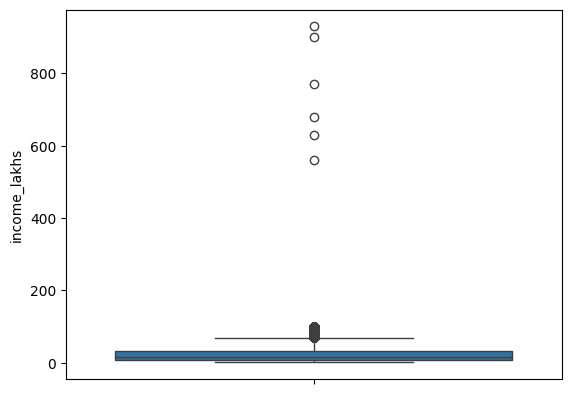

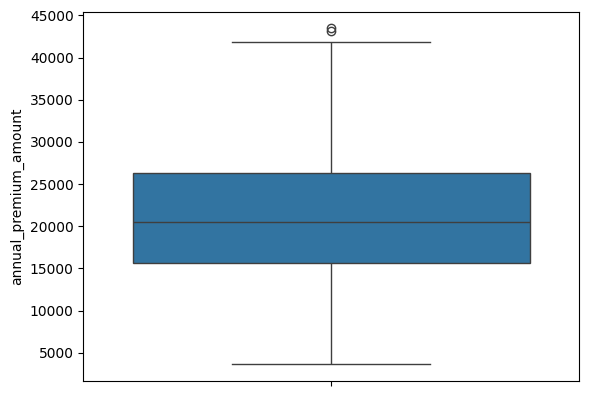

In [19]:
# fig, axes = plt.subplots(2, 2, figsize=(18, 8))  # Creates a 2x2 grid of subplots

for col in numeric_col :
    sns.boxplot(df[col])
    plt.show()



Ouliers in Age Colume

In [20]:
df[df.age>100].age.unique()

array([224, 124, 136, 203, 356])

In [21]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29828.000000,29828.000000,29828.000000,29828.000000
mean,43.095380,2.387790,23.371530,20901.900563
std,11.041991,1.420641,24.751262,6928.457636
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15706.000000
50%,42.000000,3.000000,17.000000,20496.000000
75%,52.000000,3.000000,32.000000,26361.000000
max,72.000000,5.000000,930.000000,43471.000000


Ouliers in Income_lakhs column

In [22]:
def get_iqr_bound(col):
    q1, q3 = col.quantile([0.25, 0.75])
    iqr = q3 - q1

    lower = q1 - 1.5*iqr
    higher = q3 + 1.5*iqr

    return lower, higher

In [23]:
get_iqr_bound(df.income_lakhs)

(-30.5, 69.5)

In [24]:
quantile_thresold = df.income_lakhs.quantile(0.999)
quantile_thresold

np.float64(100.0)

In [25]:
df1[df1['income_lakhs']>quantile_thresold].shape

(6, 13)

In [26]:
df2 = df1[df1['income_lakhs']<=quantile_thresold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29822.000000,29822.000000,29822.000000,29822.000000
mean,43.094896,2.387734,23.226343,20900.689223
std,11.042430,1.420644,22.455408,6928.192115
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15705.250000
50%,42.000000,3.000000,17.000000,20495.500000
75%,52.000000,3.000000,32.000000,26360.000000
max,72.000000,5.000000,100.000000,43471.000000


## Visulaization distubution


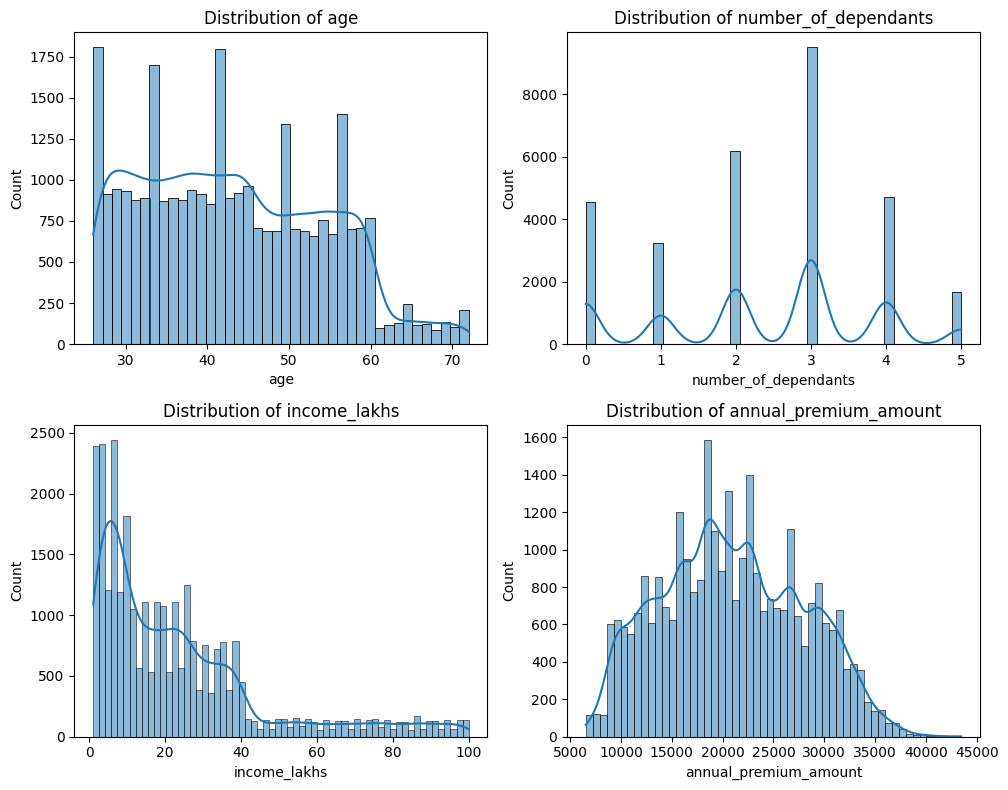

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Dynamic size based on column count

for i, col in enumerate(numeric_col):
    ax = axes[i//2, i%2]
    sns.histplot(df2[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')  # Adding title for clarity

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


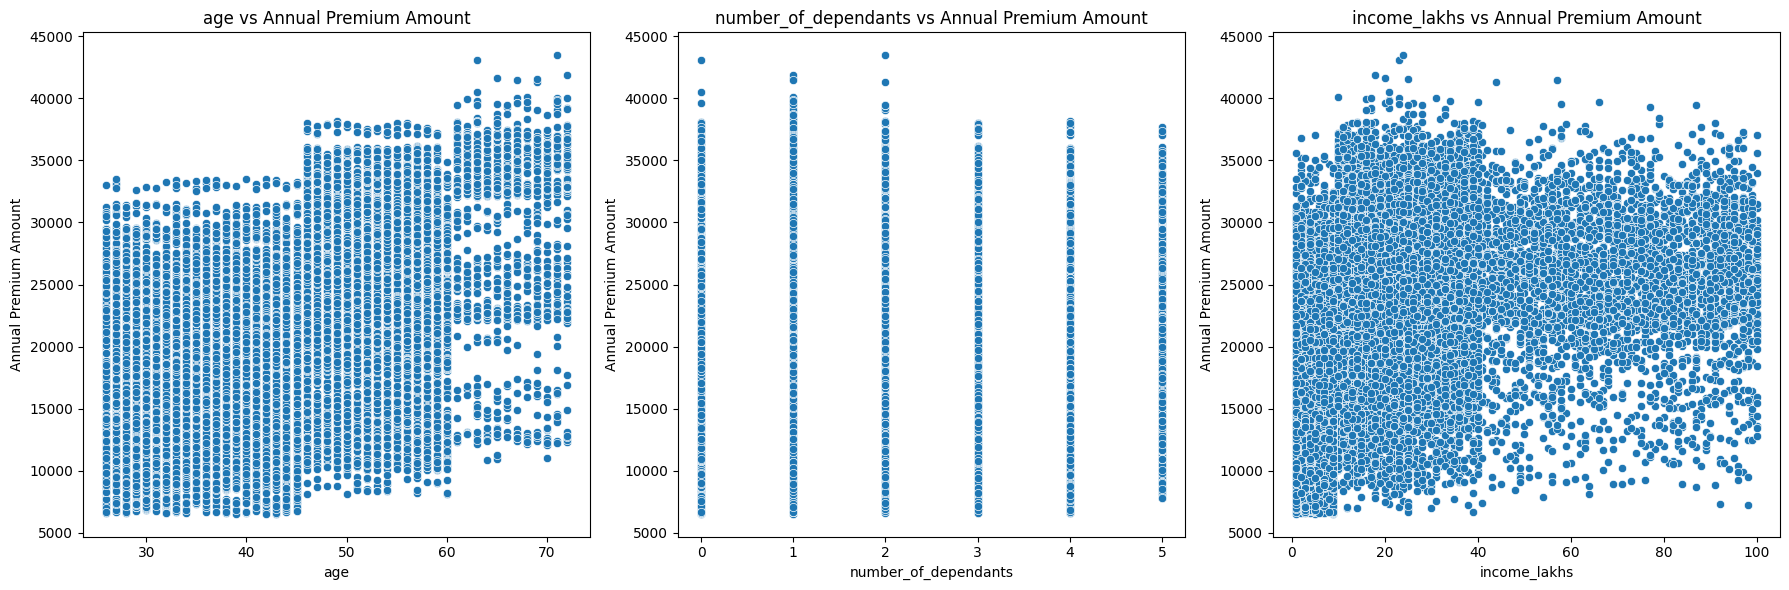

In [28]:
num_feat = ['age', 'number_of_dependants', 'income_lakhs']

fig, axes = plt.subplots(1, len(num_feat), figsize=(18, 6))  # Dynamic size based on column count

for ax, col in zip(axes, num_feat):
    sns.scatterplot(x=df2[col], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{col} vs Annual Premium Amount')
    ax.set_xlabel(col)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout to prevent overlap 
plt.show()


In [29]:
df2.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

In [30]:
cat_feat = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'medical_history', 'insurance_plan', 'income_level']

for col in cat_feat:
    print(col, ':', df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']


In [31]:
df2.smoking_status.replace({
    'Smoking=0' : 'No Smoking',
    'Does Not Smoke' : 'No Smoking',
    'Not Smoking': 'No Smoking'
}, inplace=True)
df2.smoking_status.unique()

C:\Users\chara\AppData\Local\Temp\ipykernel_9520\2529991949.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2.smoking_status.replace({


array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

<Axes: ylabel='proportion'>

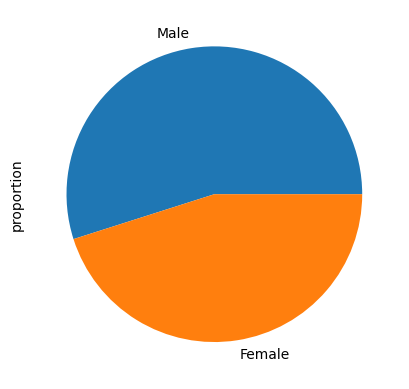

In [32]:
df2.gender.value_counts(normalize=True).plot(kind='pie')

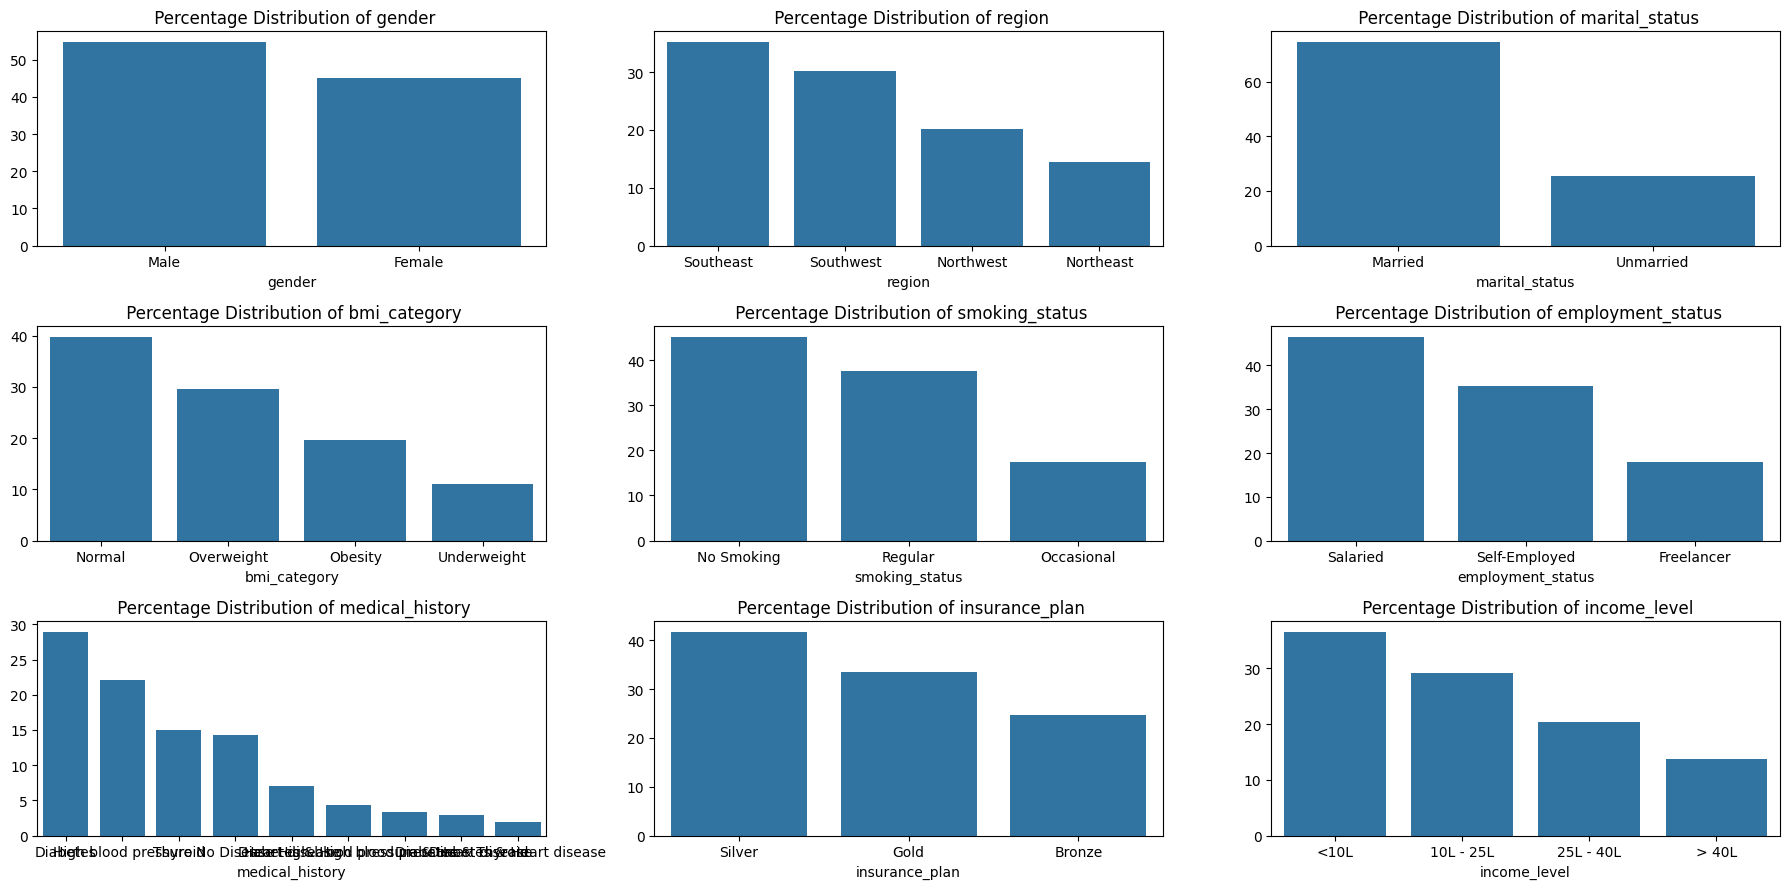

In [33]:
fig, axes = plt.subplots(3, 3, figsize=(18, 9))  # Dynamic size based on column count 
# ax = axes.flatten() 

for ax, col in zip(axes.flatten(), cat_feat): 
    
    pert = df2[col].value_counts(normalize=True)*100 
    sns.barplot(x=pert.index, y=pert.values, ax=ax) 
    ax.set_title(f' Percentage Distribution of {col}')  # Adding title for clarity 
    ax.set_xlabel(col)  

plt.tight_layout()  # Adjust layout to prevent overlap 
plt.show() 

In [34]:
cross_tab = pd.crosstab(df2.income_level, df2.insurance_plan)
cross_tab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,799,3554,4354
25L - 40L,301,2631,3142
<10L,6054,527,4341
> 40L,214,3287,618


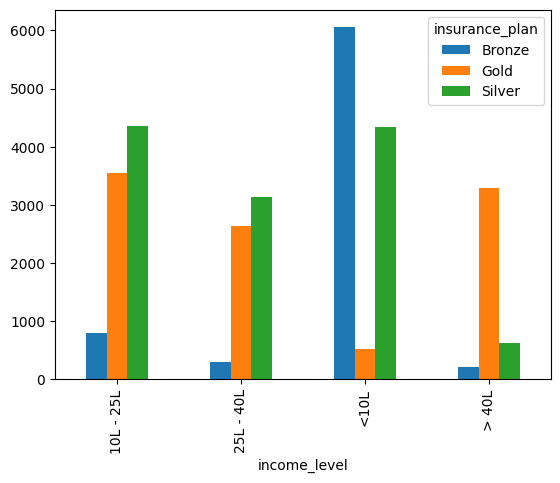

In [35]:
cross_tab.plot(kind='bar')
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

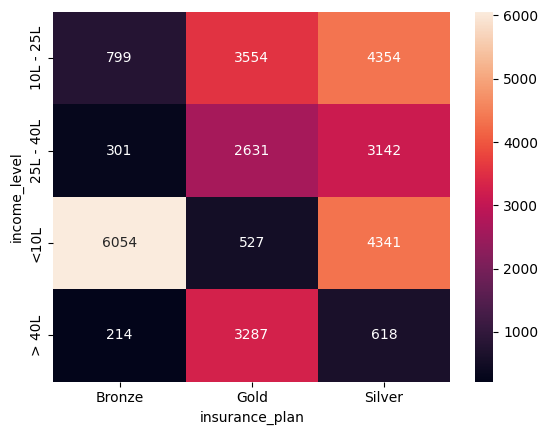

In [36]:
sns.heatmap(cross_tab, annot=True, fmt='d')

# Feature Engineering

In [37]:
# df2.fillna('None', inplace=True)
df.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [38]:
risk_score = {
    'diabetes' : 6,
    'heart disease': 8, 
    'high blood pressure': 6,
    'thyroid' : 5,
    'no disease': 0,
    'none': 0
}


In [39]:
df2[['disease1', 'disease2']] = df2.medical_history.str.split(' & ', expand=True).apply(lambda x: x.str.lower())
df2.sample(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
48548,31,Female,Northeast,Unmarried,0,Overweight,Occasional,Self-Employed,<10L,5,High blood pressure,Bronze,12443,high blood pressure,None
13098,58,Female,Northeast,Married,3,Normal,No Smoking,Self-Employed,<10L,4,High blood pressure,Silver,18914,high blood pressure,None
45377,40,Male,Southeast,Married,3,Normal,Regular,Salaried,25L - 40L,28,No Disease,Silver,16446,no disease,None
29896,45,Female,Southwest,Married,3,Underweight,Regular,Self-Employed,25L - 40L,40,No Disease,Silver,17095,no disease,None
10151,34,Male,Northeast,Married,2,Normal,Regular,Salaried,10L - 25L,18,Diabetes,Silver,18132,diabetes,None


In [40]:
df2['disease1'] = df2['disease1'].fillna('none')
df2['disease2'] = df2['disease2'].fillna('none')

In [41]:
print(df2['disease1'].unique())
print(df2['disease2'].unique())

['diabetes' 'high blood pressure' 'no disease' 'thyroid' 'heart disease']
['none' 'high blood pressure' 'heart disease' 'thyroid']


In [42]:
df2['total_risk_score'] = 0

df2['total_risk_score'] = df2.apply(lambda x: risk_score.get(x['disease1'], 0) + risk_score.get(x['disease2'], 0), axis=1)

max_sc = df2.total_risk_score.max()
min_sc = df2.total_risk_score.min()
df2['normalized_risk_score'] = (df2.total_risk_score-min_sc)/(max_sc - min_sc)

df2.sample(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
1093,65,Male,Northwest,Married,1,Underweight,No Smoking,Self-Employed,25L - 40L,38,High blood pressure,Bronze,13314,high blood pressure,none,6,0.428571
16310,26,Male,Northwest,Unmarried,1,Overweight,No Smoking,Salaried,10L - 25L,22,No Disease,Silver,15997,no disease,none,0,0.000000
39037,35,Female,Southwest,Married,3,Overweight,Regular,Salaried,> 40L,67,Thyroid,Silver,20643,thyroid,none,5,0.357143
43514,26,Male,Southeast,Married,5,Normal,No Smoking,Self-Employed,10L - 25L,10,Diabetes,Silver,15416,diabetes,none,6,0.428571
13354,58,Female,Southwest,Married,4,Obesity,No Smoking,Freelancer,<10L,7,Thyroid,Silver,22386,thyroid,none,5,0.357143


In [43]:
df2.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
disease1                 0
disease2                 0
total_risk_score         0
normalized_risk_score    0
dtype: int64

In [44]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze':1, 'Silver':2, 'Gold': 3})
df2.insurance_plan.unique()

array([1, 2, 3])

In [45]:
df2['income_level'] = df2['income_level'].map({'<10L': 1, '10L - 25L': 2, '> 40L': 3, '25L - 40L': 4})
df2['income_level'].unique()

array([1, 2, 3, 4])

In [46]:
df2.sample(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
10333,37,Male,Northeast,Unmarried,1,Normal,Regular,Self-Employed,3,83,No Disease,3,22837,no disease,none,0,0.000000
30211,28,Female,Northwest,Married,2,Normal,Occasional,Freelancer,2,23,High blood pressure,1,9844,high blood pressure,none,6,0.428571
47698,37,Male,Southwest,Married,3,Normal,Regular,Salaried,3,86,Diabetes,3,24831,diabetes,none,6,0.428571
46224,33,Female,Southwest,Married,3,Obesity,Regular,Freelancer,2,22,Diabetes,2,22882,diabetes,none,6,0.428571
33880,45,Female,Northeast,Married,2,Underweight,No Smoking,Salaried,1,4,Diabetes & Heart disease,1,13642,diabetes,heart disease,14,1.000000


In [47]:
nomial_col = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status' ]

df3 = pd.get_dummies(df2, columns=nomial_col, drop_first=True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,3,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
5,56,3,2,14,Diabetes,1,15610,diabetes,none,6,...,0,0,0,1,0,0,1,0,0,1


In [48]:
df4 = df3.drop(columns=['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,3,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
5,56,3,2,14,1,15610,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


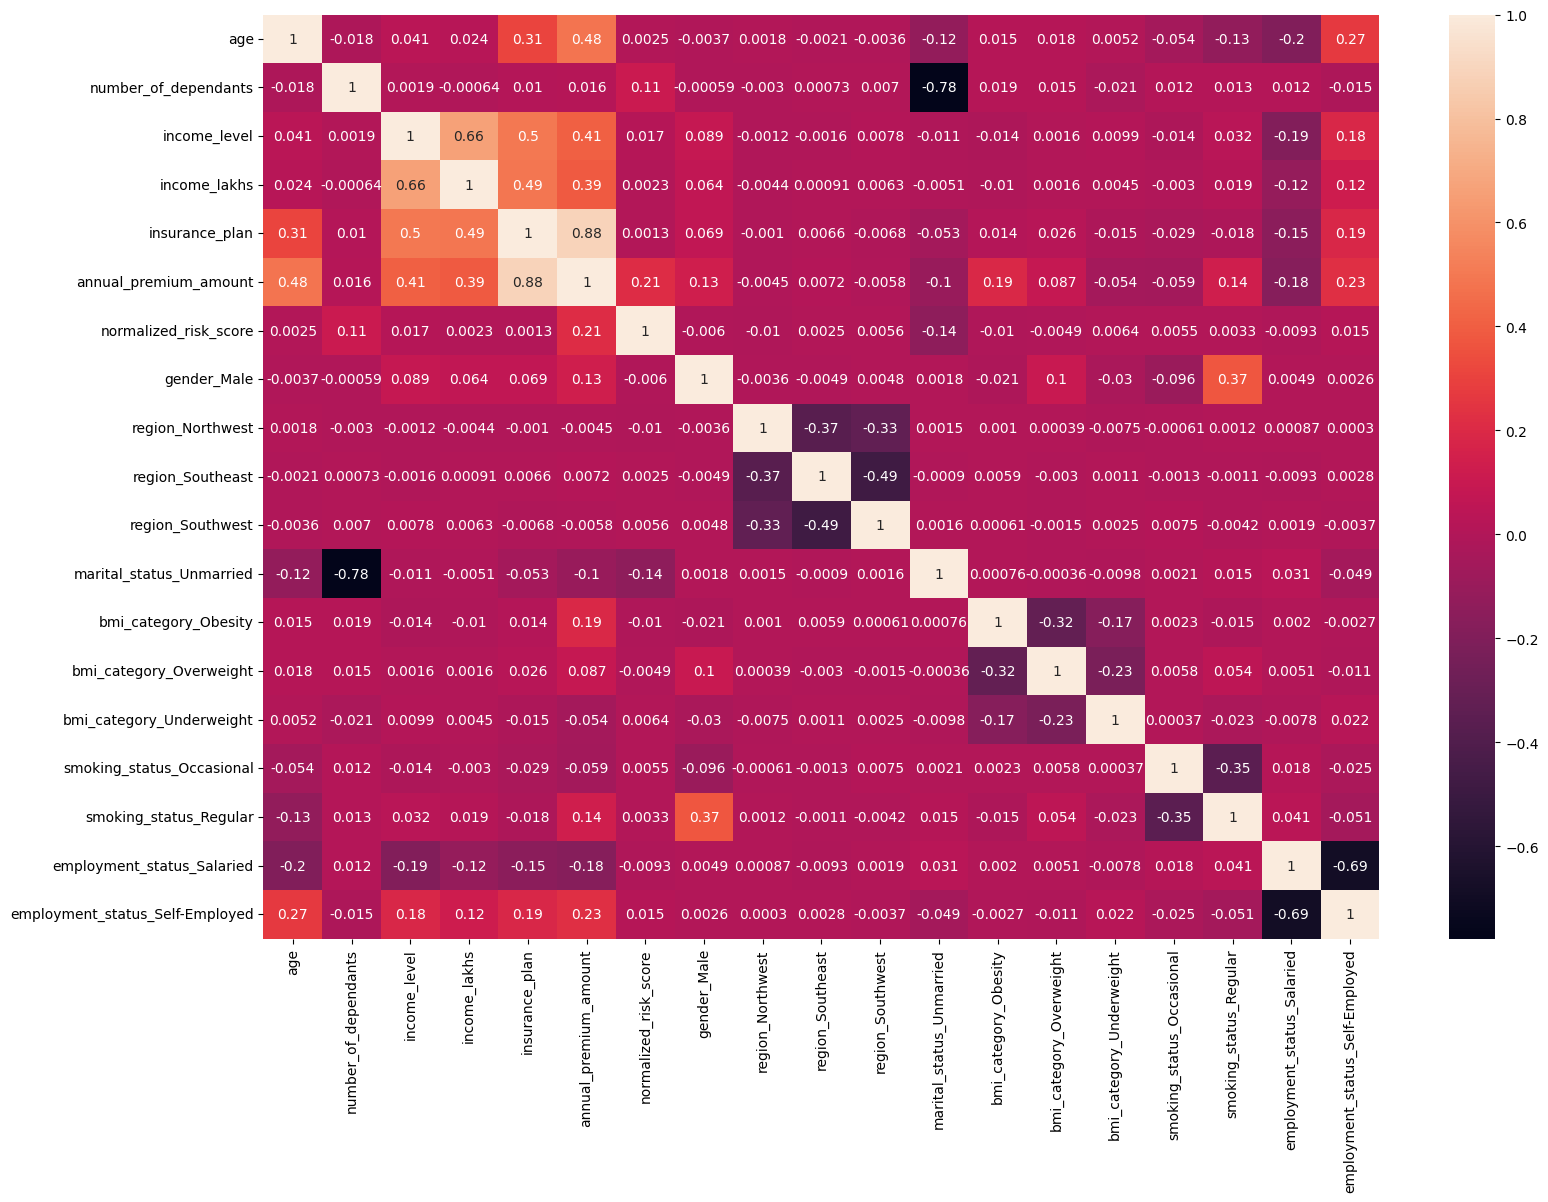

In [49]:
cm = df4.corr()

plt.figure(figsize=(18, 12))
sns.heatmap(cm, annot=True)
plt.show()

MinMaxScaling Cols

In [50]:
X = df4.drop('annual_premium_amount', axis=1)
y = df4['annual_premium_amount']

X.head()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,3,77,3,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
5,56,3,2,14,1,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


In [51]:
col_scale = ['age', 'number_of_dependants', 'income_lakhs', 'income_level', 'insurance_plan']

scaler = MinMaxScaler()
X[col_scale] = scaler.fit_transform(X[col_scale])

X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.393077,0.224509,0.544112,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.378150,0.226822,0.379009,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif(data):
    vif_df = pd.DataFrame()
    vif_df['column'] = data.columns
    vif_df['vif'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df


In [53]:
vif(X)

,column,vif
0,age,3.882319
1,number_of_dependants,6.292550
2,income_level,4.104266
3,income_lakhs,3.797992
4,insurance_plan,4.931114
5,normalized_risk_score,3.815157
6,gender_Male,2.599039
7,region_Northwest,2.124859
8,region_Southeast,2.981854
9,region_Southwest,2.711344


# Model Training

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

In [55]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((20875, 18), (8947, 18), (20875,), (8947,))

In [56]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
model_lr.score(X_test, y_test)


0.9538488637853493

In [57]:
train_score = model_lr.score(X_train, y_train)
teat_score = model_lr.score(X_test, y_test)

train_score, teat_score

(0.9534180152243901, 0.9538488637853493)

In [58]:
feature_importance = model_lr.coef_

coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['coeff'])
coef_df = coef_df.sort_values(by='coeff', ascending=True)

coef_df

,coeff
number_of_dependants,-1311.773685
marital_status_Unmarried,-700.402071
income_lakhs,-678.934938
region_Northwest,-55.061781
employment_status_Salaried,-47.752599
income_level,-32.936399
region_Southwest,-22.029674
region_Southeast,-19.549077
gender_Male,38.398903
employment_status_Self-Employed,243.684383


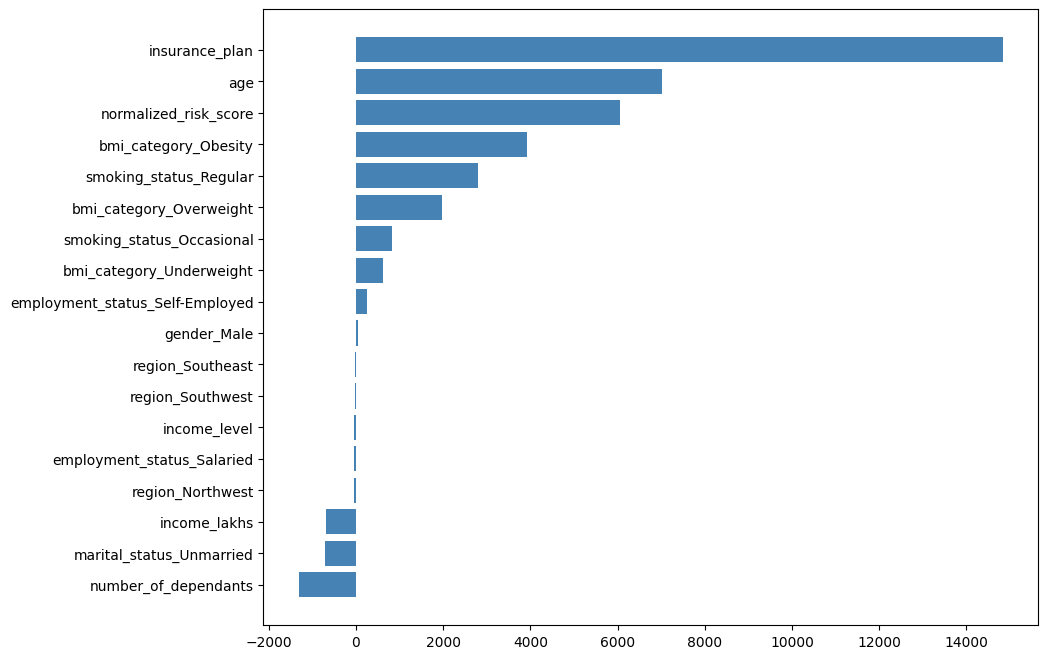

In [59]:
plt.figure(figsize=(10, 8))
plt.barh(coef_df.index, coef_df.coeff, color='steelblue')
plt.show()

In [60]:
from xgboost import XGBRegressor

model_xg = XGBRegressor()
model_xg.fit(X_train, y_train)

train_score = model_xg.score(X_train, y_train)
teat_score = model_xg.score(X_test, y_test)

train_score, teat_score


(0.9986435174942017, 0.997962236404419)

RandamSearch cross Validation

In [61]:
param_grid = {
    'n_estimator' : [20, 40, 50],
    'learning_rate': [0.01, 0.01, 0.2],
    'max_depth' : [3, 4, 5]
}

random_search = RandomizedSearchCV(model_xg, param_grid, n_iter=10,  cv=5, scoring='r2', random_state=42)
random_search.fit(X_train, y_train)
random_search.best_score_

c:\ProgramData\anaconda3\envs\py-latest\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:47:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\ProgramData\anaconda3\envs\py-latest\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:47:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\ProgramData\anaconda3\envs\py-latest\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:47:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\ProgramData\anaconda3\envs\py-latest\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:47:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimato

np.float64(0.9980824589729309)

In [62]:
random_search.best_params_

{'n_estimator': 20, 'max_depth': 5, 'learning_rate': 0.2}

In [63]:
best_model = random_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimator=20,
             n_estimators=None, n_jobs=None, ...)

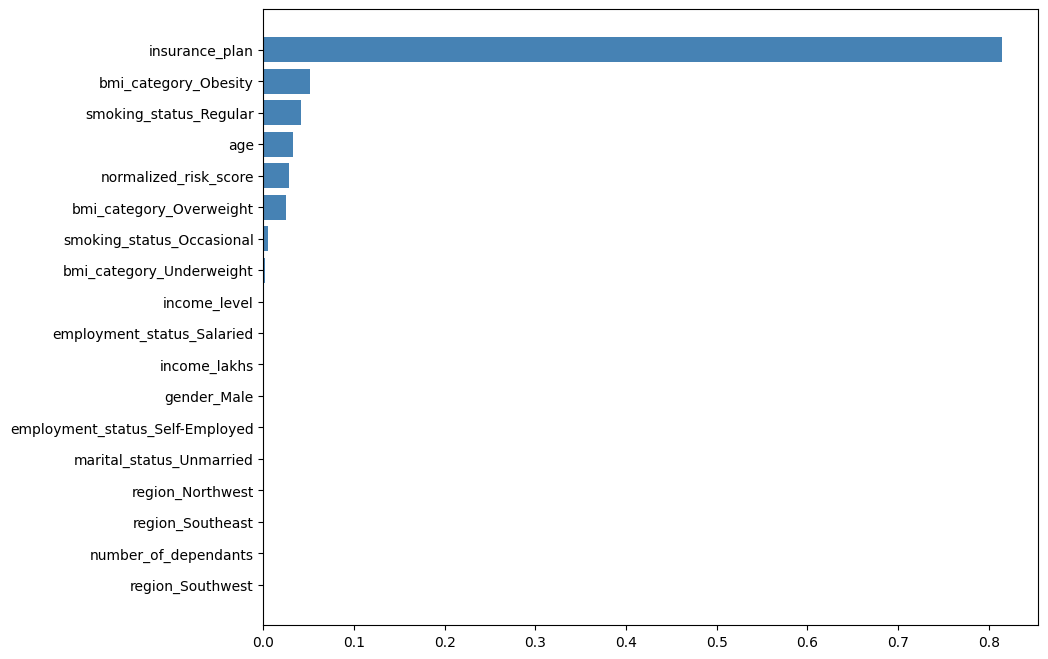

In [64]:
feature_importance = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['coeff'])
coef_df = coef_df.sort_values(by='coeff', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(coef_df.index, coef_df.coeff, color='steelblue')
plt.show()

# Error analysis

In [65]:
y_pred = best_model.predict(X_test)

resd  = y_pred-y_test
resd_per = resd*100/y_test

results_df = pd.DataFrame({
    'acutal': y_test,
    'predicted': y_pred,
    'dif': resd,
    'diff_pct': resd_per

})

results_df.head()


,acutal,predicted,dif,diff_pct
32969,26895,26583.175781,-311.824219,-1.159413
24737,22734,23054.892578,320.892578,1.411510
33333,21198,21557.101562,359.101562,1.694035
49528,9100,9066.999023,-33.000977,-0.362648
28662,26434,26569.423828,135.423828,0.512309


<Axes: xlabel='diff_pct', ylabel='Count'>

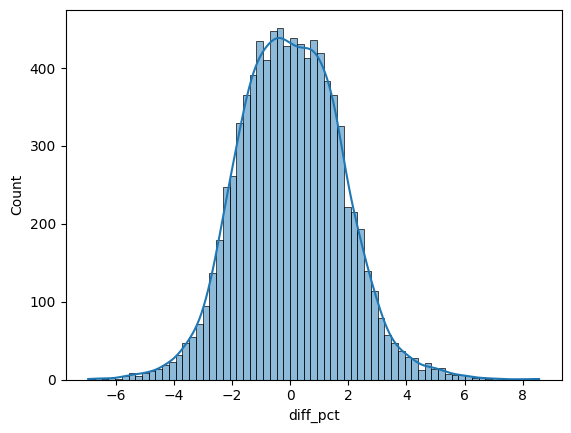

In [66]:
sns.histplot(results_df.diff_pct, kde=True)

In [67]:
error_threshold = 10

error_pred = results_df[abs(results_df.diff_pct)>error_threshold]
error_pred.shape

(0, 4)

In [68]:
error_pred.shape[0]*100/results_df.shape[0]

0.0

In [69]:
results_df[abs(results_df.diff_pct)>50].sort_values(by='diff_pct', ascending=False)


,acutal,predicted,dif,diff_pct


In [70]:
error_df = X_test.loc[error_pred.index]
error_df

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed


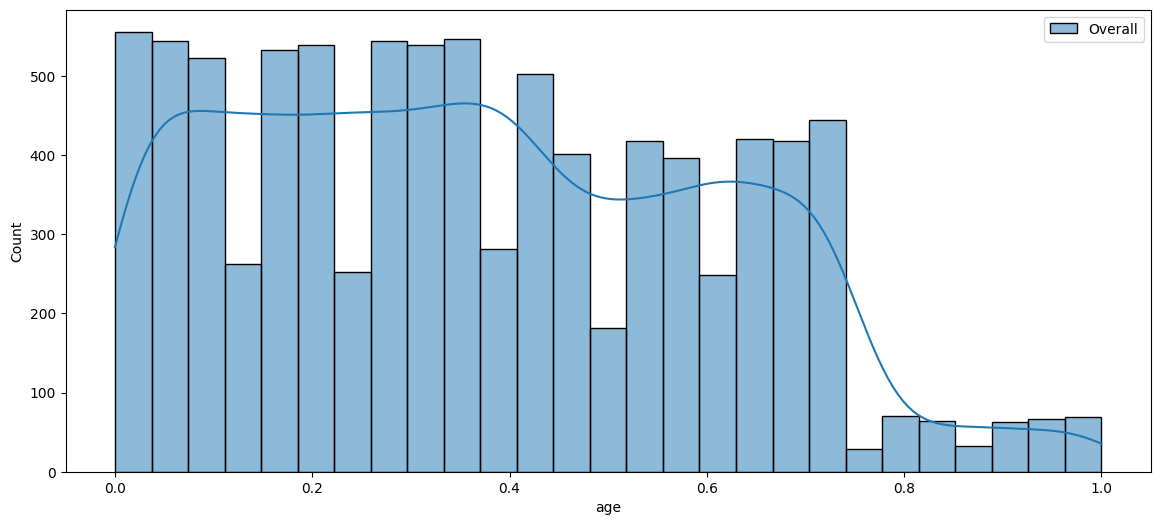

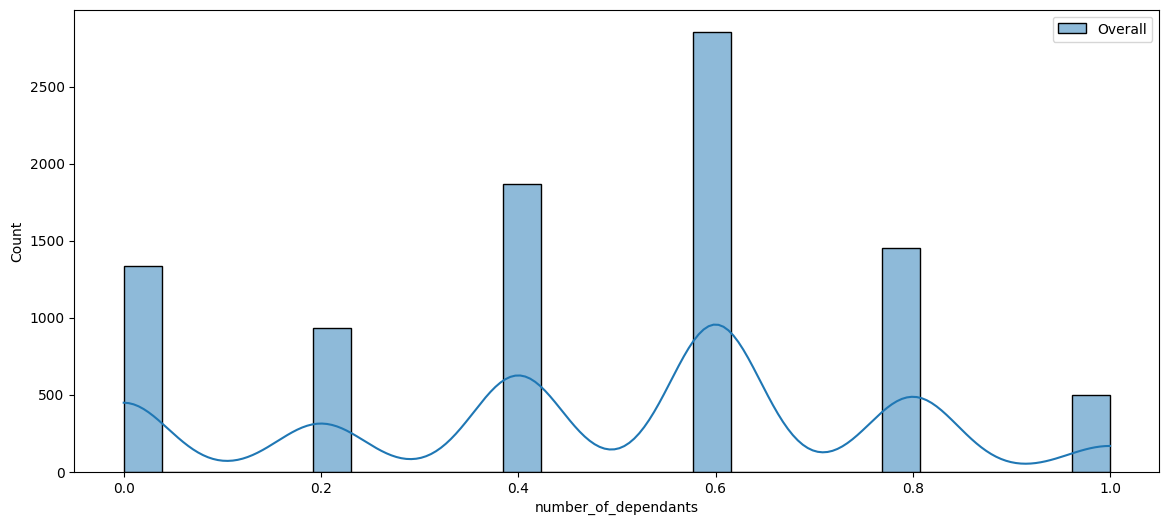

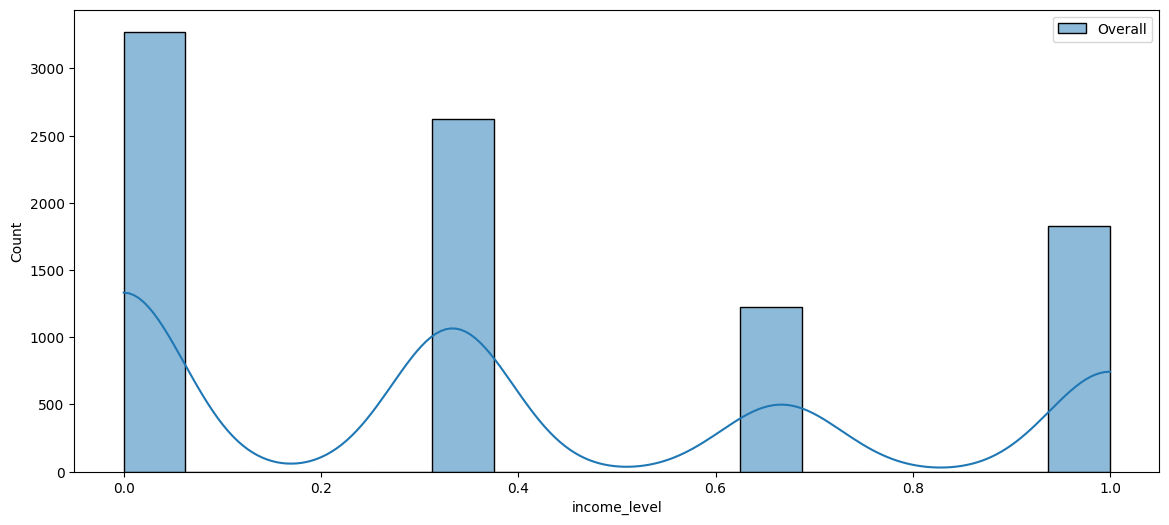

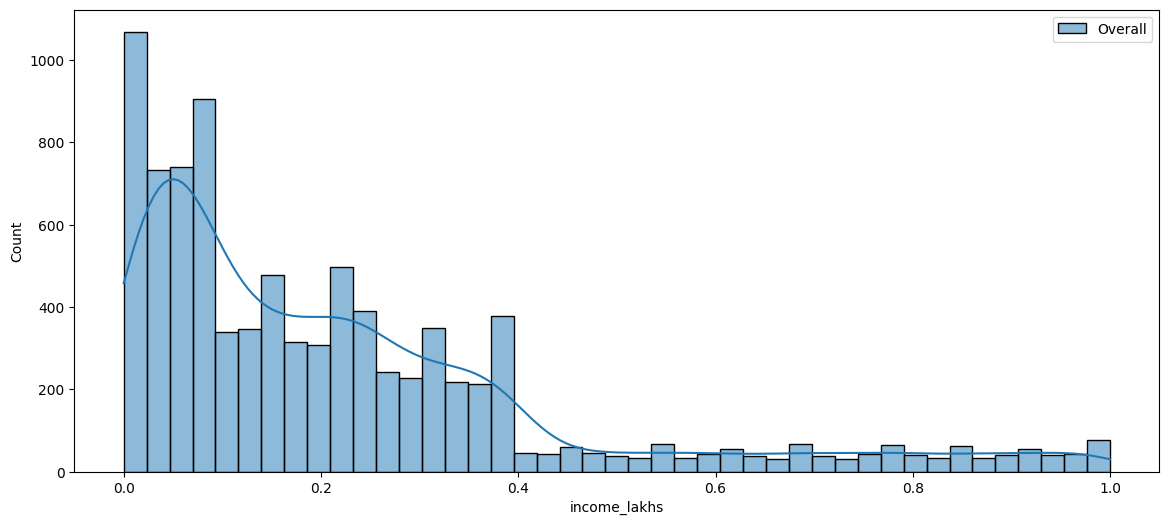

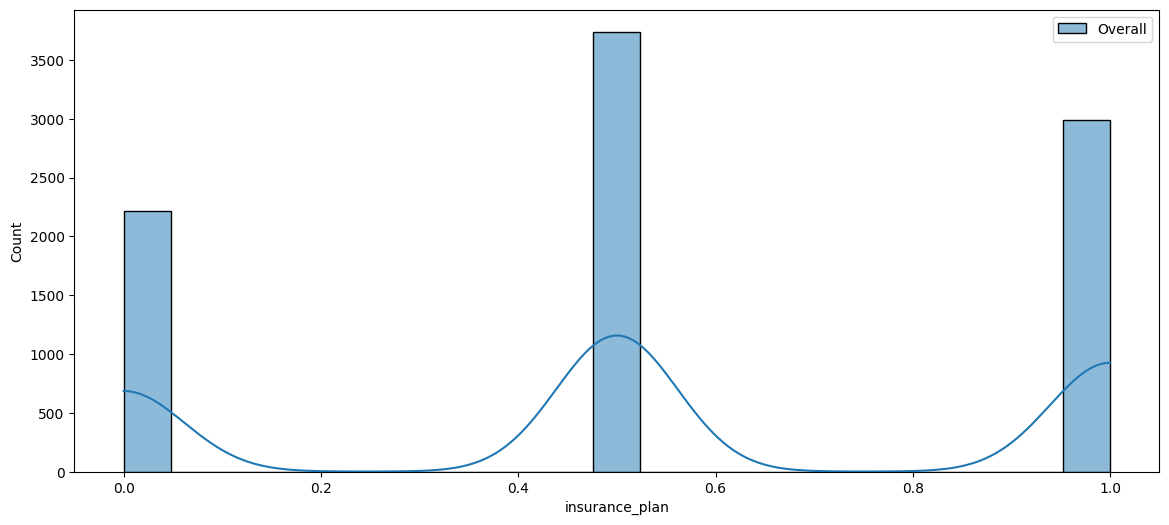

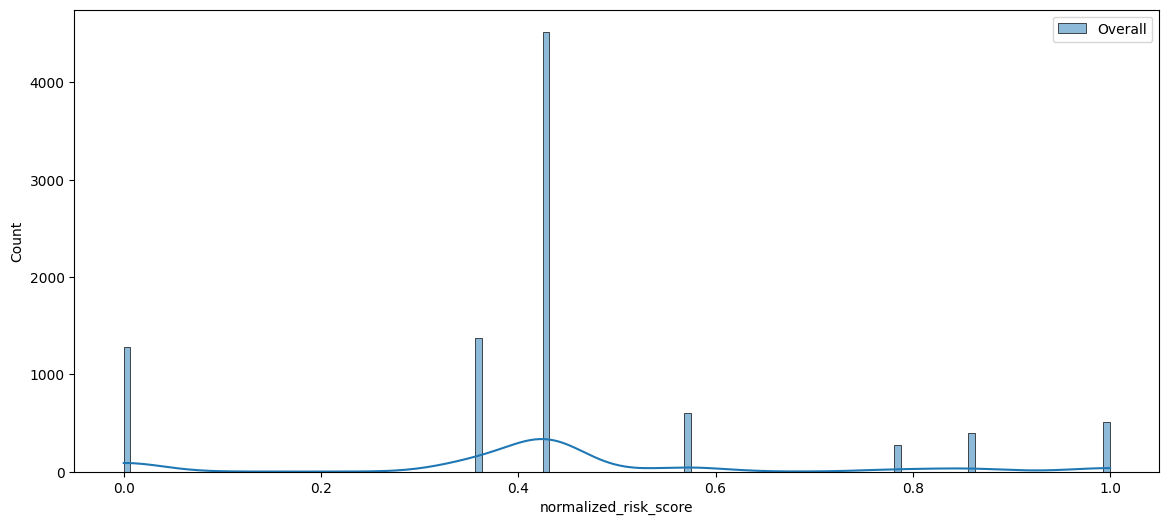

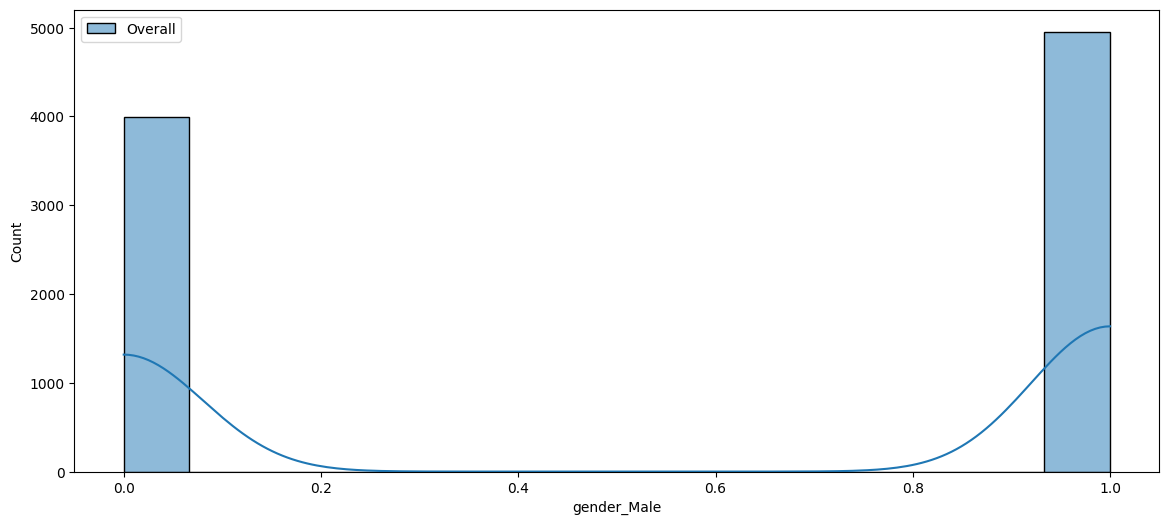

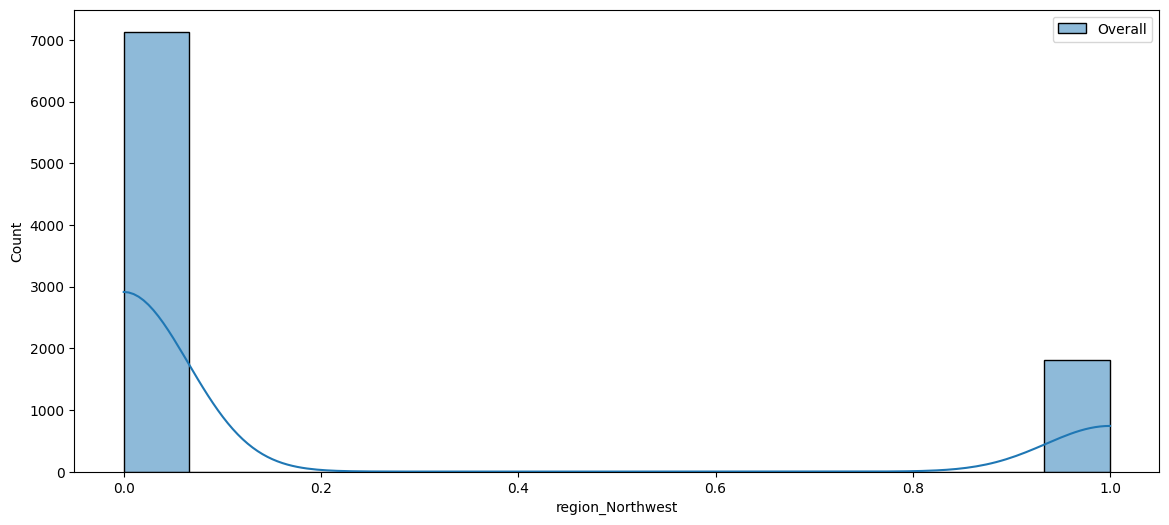

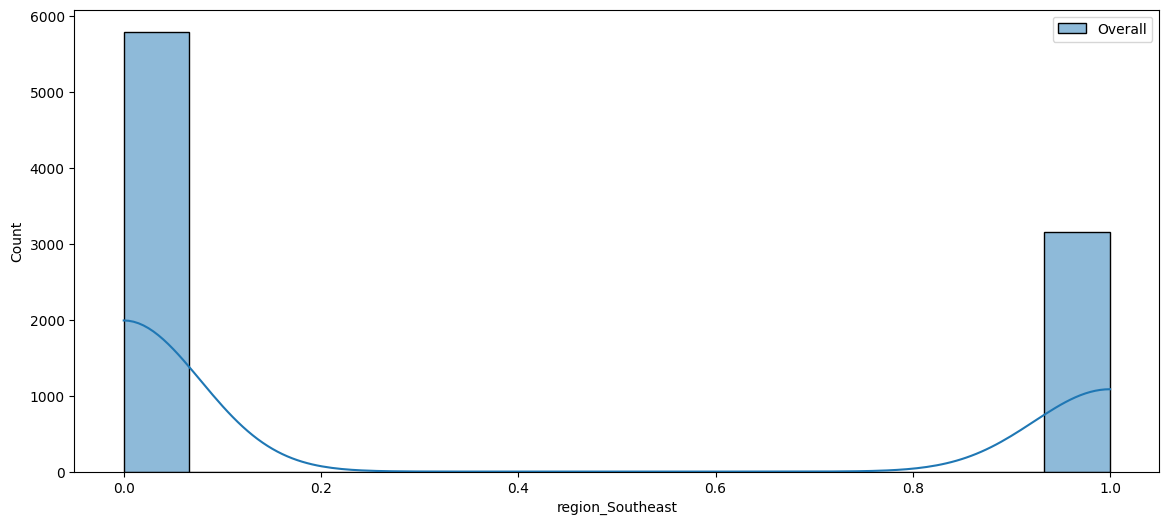

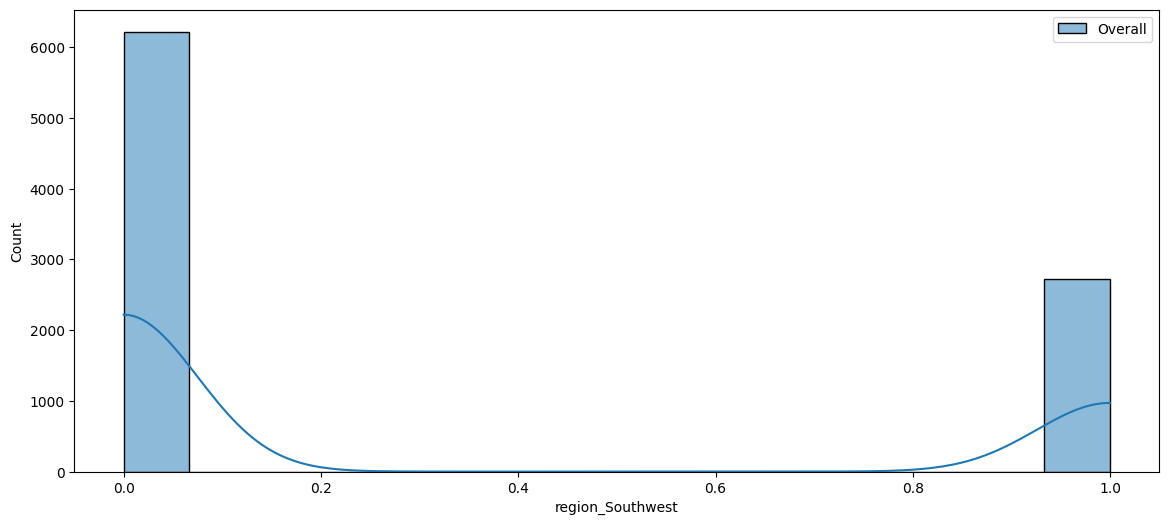

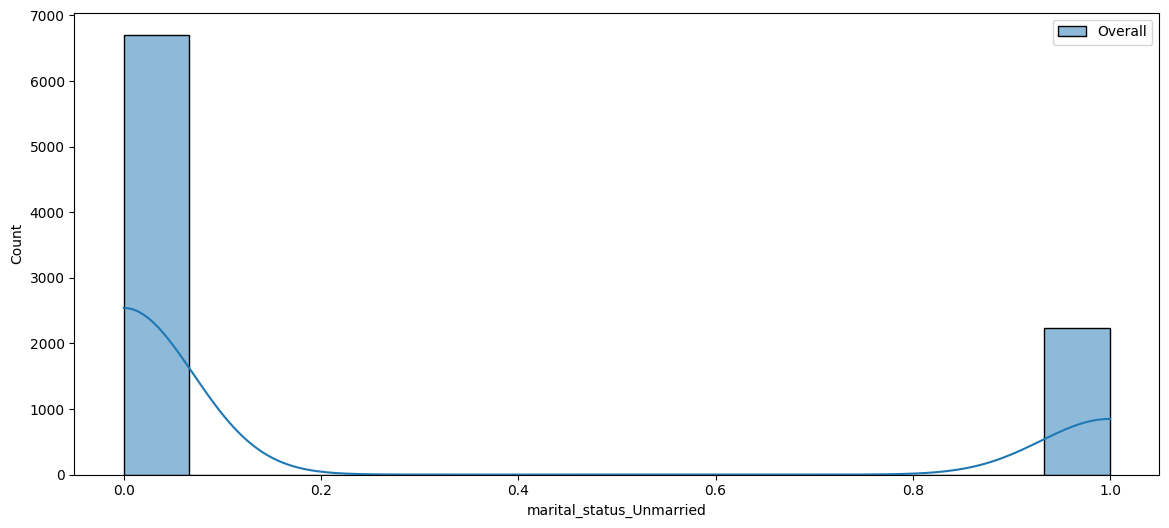

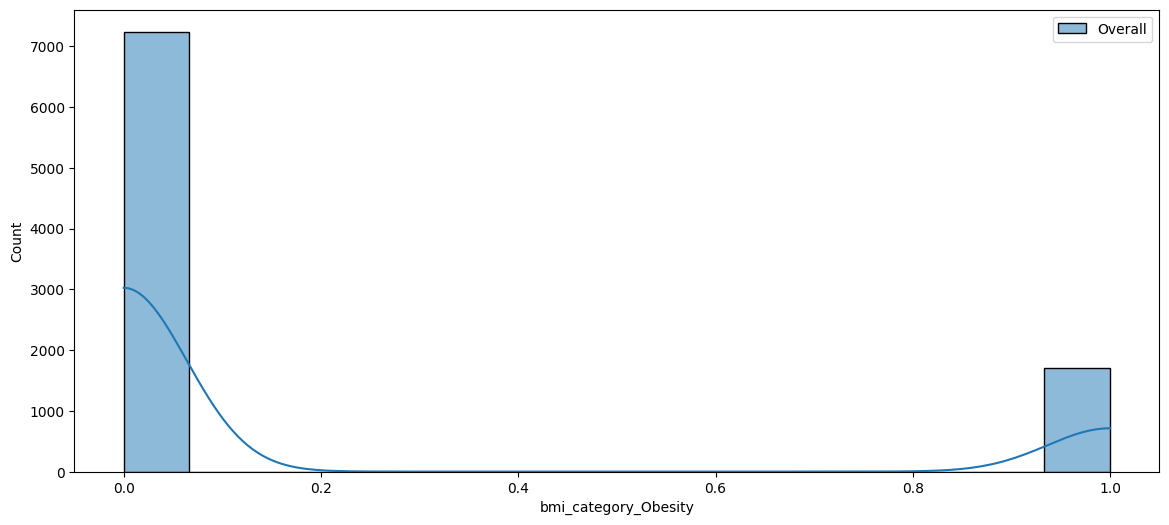

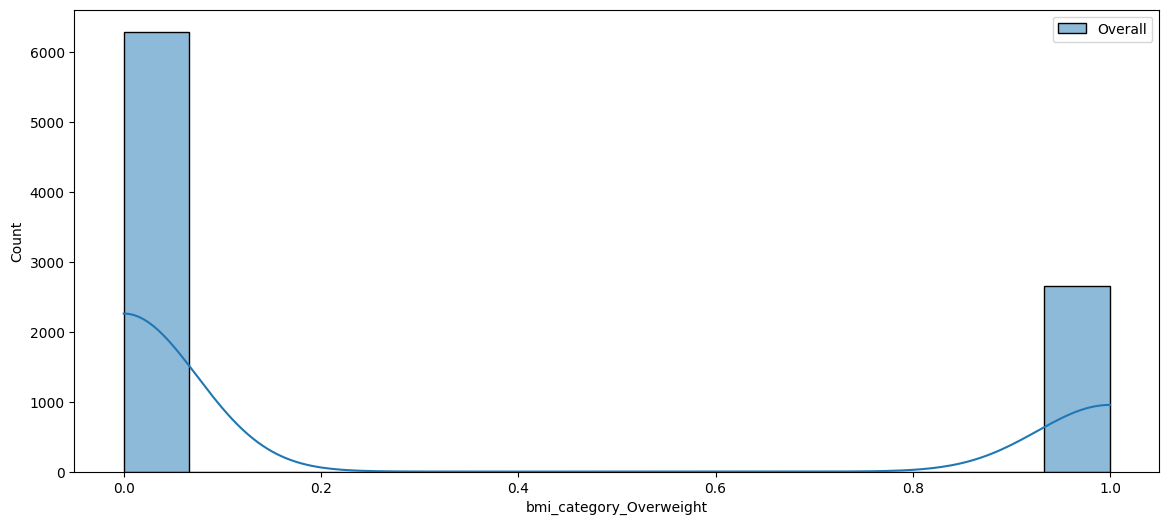

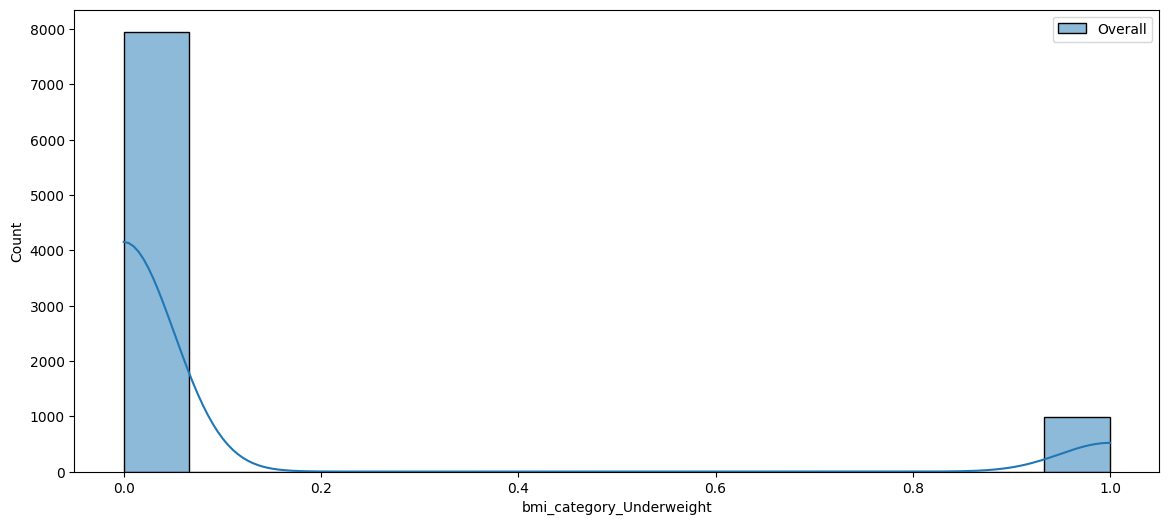

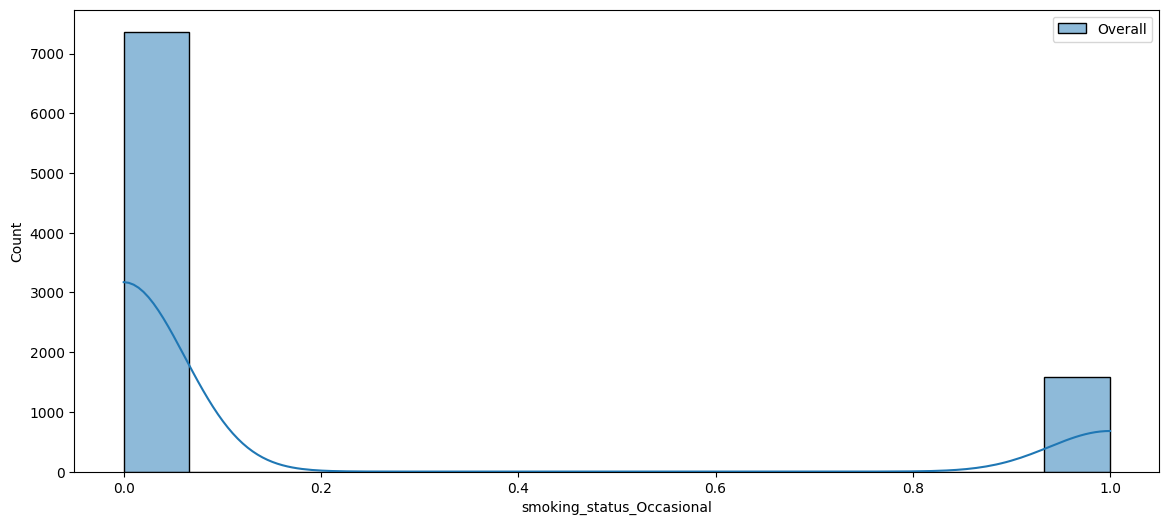

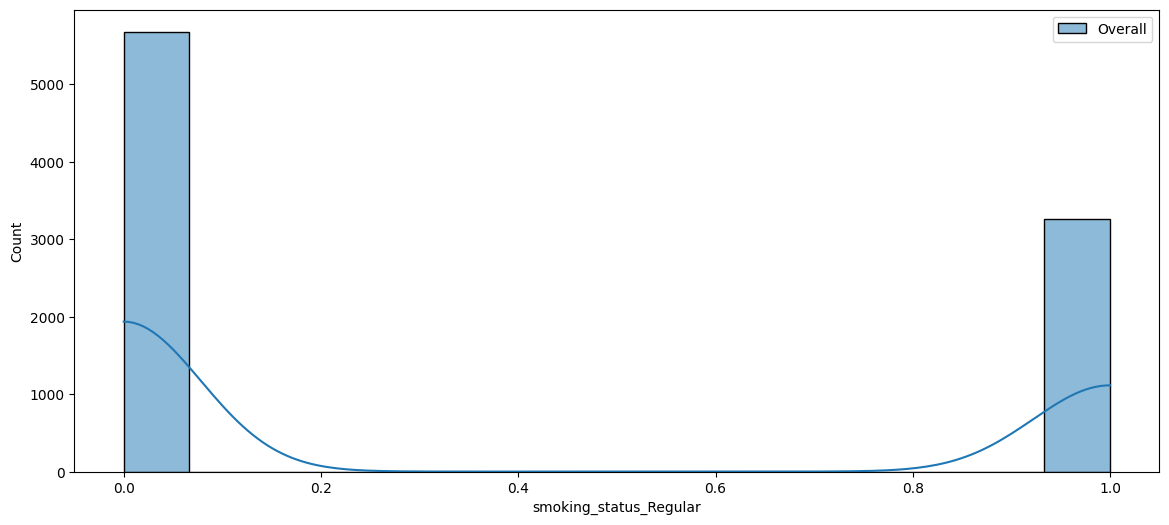

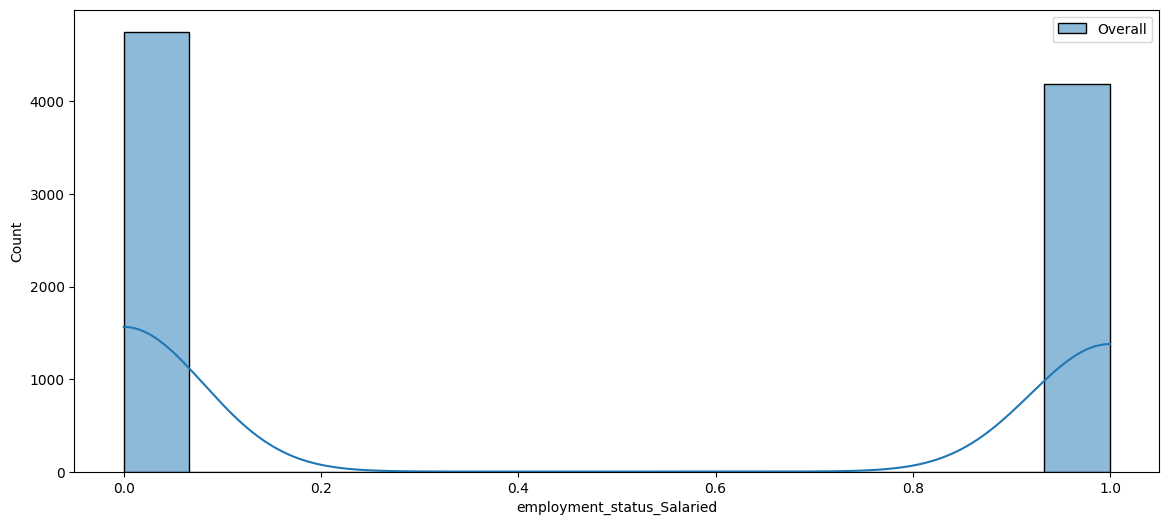

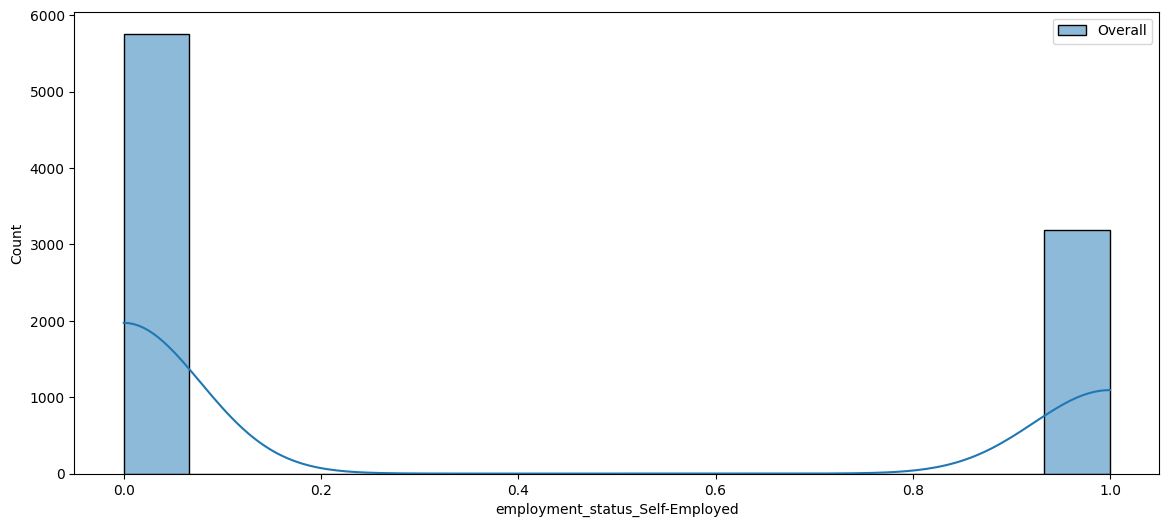

In [71]:
for col in X_test.columns:
    plt.figure(figsize=(14, 6))
    sns.histplot(X_test[col], kde=True, label='Overall')
    sns.histplot(error_df[col], kde=True, label='error')
    plt.legend()
    plt.show()

we can observe some insighs in age Distribution

In [73]:

df_unscale = pd.DataFrame()

df_unscale[col_scale] = scaler.inverse_transform(error_df[col_scale])
df_unscale

ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required.

<Axes: xlabel='age', ylabel='Count'>

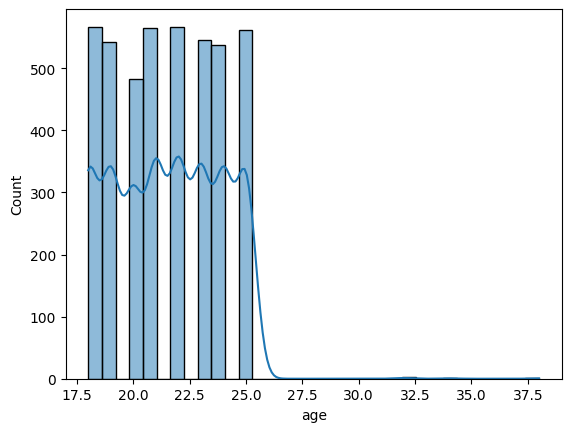

In [ ]:
sns.histplot(df_unscale.age, kde=True)

In [ ]:
df_unscale.age.quantile(0.999)

np.float64(25.0)

# Export Model

In [74]:
from joblib import dump

dump(best_model, 'model_rest.joblib')

['model_rest.joblib']

In [5]:
scaler_with_col = {
    'scaler': scaler,
    'columns': col_scale
}

scaler_with_col
# dump(scaler_with_col, 'scaler_young.joblib')

{'scaler': MinMaxScaler(),
 'columns': ['age',
  'number_of_dependants',
  'income_lakhs',
  'income_level',
  'insurance_plan']}